In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

In [3]:
DATA_PATH = '/Users/shovitraj/Github/Python/MagNet_data/'

In [6]:
dst = pd.read_csv(DATA_PATH +"dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH + "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH + "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [7]:
# df=pd.read_csv('/Users/shovitraj/Github/Python/MagNet_data/hourly_df.csv',
#                index_col=['timedelta','period'])
# df.head(2)

In [8]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)


In [9]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [10]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()


(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [11]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [12]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [13]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [14]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)


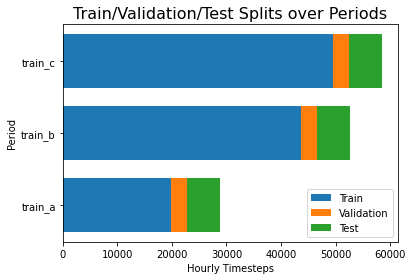

In [15]:
def plots():
    ind = [0, 1, 2]
    names = ["train_a", "train_b", "train_c"]
    width = 0.75
    train_cnts = [len(df) for _, df in train.groupby("period")]
    val_cnts = [len(df) for _, df in val.groupby("period")]
    test_cnts = [len(df) for _, df in test.groupby("period")]

    p1 = plt.barh(ind, train_cnts, width)
    p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
    p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

    plt.yticks(ind, names)
    plt.ylabel("Period")
    plt.xlabel("Hourly Timesteps")
    plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
    plt.legend(["Train", "Validation", "Test"])
    
plots()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing

In [17]:

data_config = {
    "timesteps": 32,
    "batch_size": 64,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 1762
Number of val batches: 138


In [27]:
# define our model
model_config = {"n_epochs": 25, "n_neurons": 32, "dropout": 0.4, "stateful": False}

def make_model():

    model = Sequential()
    model.add(
        LSTM(
            model_config["n_neurons"],
            # usually set to (`batch_size`, `sequence_length`, `n_features`)
            # setting the batch size to None allows for variable length batches
            batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
            stateful=model_config["stateful"],
            dropout=model_config["dropout"],
        )
    )
    
    model.add(Dense(64))
    model.add(Dense(64))
    
    model.add(Dense(len(YCOLS)))
    model.compile(
        loss="mean_squared_error",
        optimizer="adam",
    )
    return model

model = make_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 130       
Total params: 12,546
Trainable params: 12,546
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
)


Epoch 1/25
1762/1762 [==============================] - 21s 11ms/step - loss: 350.4193 - val_loss: 308.1606
Epoch 2/25
1762/1762 [==============================] - 19s 11ms/step - loss: 248.1462 - val_loss: 277.5281
Epoch 3/25
1762/1762 [==============================] - 17s 10ms/step - loss: 227.1318 - val_loss: 260.5728
Epoch 4/25
1762/1762 [==============================] - 17s 10ms/step - loss: 216.8192 - val_loss: 244.4245
Epoch 5/25
1762/1762 [==============================] - 17s 10ms/step - loss: 206.1445 - val_loss: 218.8594
Epoch 6/25
1762/1762 [==============================] - 17s 10ms/step - loss: 200.1624 - val_loss: 202.7840
Epoch 7/25
1762/1762 [==============================] - 18s 10ms/step - loss: 198.5425 - val_loss: 193.0418
Epoch 8/25
1762/1762 [==============================] - 18s 10ms/step - loss: 196.7036 - val_loss: 194.8171
Epoch 9/25
1762/1762 [==============================] - 17s 10ms/step - loss: 190.6041 - val_loss: 199.7170
Epoch 10/25
1762/1762 [=====

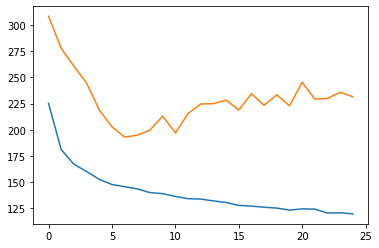

In [29]:
for name, values in history.history.items():
    plt.plot(values)

In [30]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])

In [31]:
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

279/279 [==============================] - 2s 5ms/step - loss: 197.1061
Test RMSE: 14.04


In [32]:
import json
import pickle

model.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


{'timesteps': 32, 'batch_size': 64, 'solar_wind_subset': ['bt', 'temperature', 'bx_gse', 'by_gse', 'bz_gse', 'speed', 'density']}


In [ ]:
import json
import pickle
from typing import Tuple
from tensorflow import keras
import numpy as np
import pandas as pd

# Load in serialized model, config, and scaler
model = keras.models.load_model("model")

with open("config.json", "r") as f:
    CONFIG = json.load(f)

with open("scaler.pck", "rb") as f:
    scaler = pickle.load(f)

# Set global variables    
TIMESTEPS = CONFIG["timesteps"]
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


# Define functions for preprocessing
def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby([feature_df.index.floor("H")]).agg(aggs)

    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler


# THIS MUST BE DEFINED FOR YOUR SUBMISSION TO RUN
def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """
    Take all of the data up until time t-1, and then make predictions for
    times t and t+1.
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"] = latest_sunspot_number
    
    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1, TIMESTEPS, features.shape[1])
    )
    
    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1